# CSI 5238 Homework Exercise 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import preprocessing
torch.set_default_tensor_type('torch.DoubleTensor')

### Generate input and output
Generate random input x between 0 and 1 exclusively, and generate out using function f(x).

Test gaussian random distribution.

In [51]:
def functionx(x, sigma, mu=0):
    return np.cos(2*np.pi*x) + (sigma*np.random.randn(x.size,1) + mu)

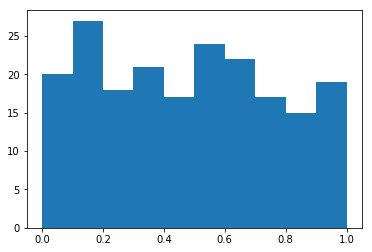

In [57]:
# Test functionx
n, sigma = 200, 0.1
x = np.random.uniform(low=0, high=1, size=(n,1))
y = functionx(x, sigma)
bins = int(n/20)
plt.hist(x, bins)
plt.show()

In [7]:
def getData(n, sigma, is_numpy=False, preprocess=False):
    x = np.random.uniform(low=0, high=1, size=(n,1))
    y = functionx(x, sigma)
    
    if preprocess:
        x = preprocessing.scale(x)
        y = preprocessing.scale(y)
    
    if is_numpy:
        return x, y
    return Variable(torch.from_numpy(x)), Variable(torch.from_numpy(y))

Graph input and output results.

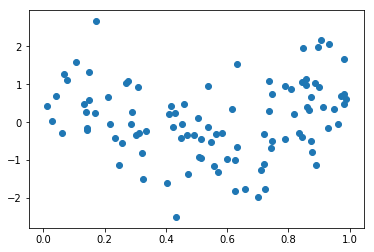

In [109]:
n = 100
sigma = 1
x, y = getData(n, sigma, is_numpy=True, preprocess=False)

plt.scatter(x, y)
plt.show()

### Define loss function, polynomial feature function, linear regression model

In [60]:
def getMSE(y_pred, y, w, lambd, is_numpy=False):
    if is_numpy:
        m = w.size
        return np.mean((y_pred - y)**2) + lambd*(1/m)*np.mean((np.dot(w.T, w)))
    
    m = w.size()[1]
    return torch.mean((y_pred - y)**2) + lambd*(1/m)*((torch.mm(w.t(), w))[0][0])

In [61]:
# Test getMSE
y_pred = torch.Tensor([[1.5],[1]])
y = torch.Tensor([[2],[2]])
w = torch.Tensor([[1],[1]])
lambd = 1
print(getMSE(y_pred, y, w, lambd))
print(torch.mean((y_pred - y)**2))
print(torch.mm(w.t(), w)[0][0])

tensor(2.6250)
tensor(0.6250)
tensor(2.)


In [62]:
def polynomialx(x, d, is_numpy=False):
    if d == 0:
        x = np.zeros_like(x)
    else:
        poly = preprocessing.PolynomialFeatures(d, include_bias=False)
        x = poly.fit_transform(x)
        
    if is_numpy is False:
        x = torch.from_numpy(x)
    return x

In [63]:
# Test polynomialx
x = np.array([[2], [3], [4]])
d = 0
print(polynomialx(x,d))

tensor([[0],
        [0],
        [0]], dtype=torch.int32)


In [64]:
class LrModule(nn.Module):

    def __init__(self, d):
        super(LrModule, self).__init__()
        if d == 0: d = 1
        self.linear = nn.Linear(d,1)

    def forward(self, x):
        # linear
        return self.linear(x)

In [65]:
# Check LrModule
lr = LrModule(5)
print(lr.linear)
print(lr.linear.weight.data)
print(lr.linear.bias.data)
x = torch.Tensor([[1, 1, 1, 1, 1], [2, 2, 2, 2, 2]])
print(lr.forward(x))

Linear(in_features=5, out_features=1, bias=True)
tensor([[ 0.0201,  0.2254, -0.3593,  0.2317,  0.1686]])
tensor([-0.3908])
tensor([[-0.1043],
        [ 0.1822]], grad_fn=<ThAddmmBackward>)


In [66]:
# Test getMSE
x = np.array([[1,2], [1,3], [1,4], [1,5]])
y = np.array([[7], [6], [5], [4]])
w = np.array([[0.1], [0.2]])
y_pred = np.dot(x,w)
res = getMSE(y_pred, y, w, lambd=0, is_numpy=True)
assert res == 23.89

### Gradient Checking

In [67]:
def gradApprox(lr, x, y, lambd, e=1e-2):
    w = lr.linear.weight.data
    w = w.detach().numpy()
    y = y.detach().numpy()
    dwa = np.zeros_like(w)
    
    i = 0
    for val in w[0]:
        wp, wm = w.copy(), w.copy()

        wp[0][i] += e
        wm[0][i] -= e
        
        lr.linear.weight.data = torch.from_numpy(wp)
        y_pred = lr.forward(x)
        y_pred = y_pred.detach().numpy()
        jp = getMSE(y_pred, y, wp, lambd, is_numpy=True)
        
        lr.linear.weight.data = torch.from_numpy(wm)
        y_pred = lr.forward(x)
        y_pred = y_pred.detach().numpy()
        jm = getMSE(y_pred, y, wm, lambd, is_numpy=True)

        dwa[0][i] = (jp - jm)/(2*e)
        i += 1
    
    return dwa

In [68]:
def checkGrad(lr, x, y, lambd):
    dw = lr.linear.weight.grad
    dw = dw.detach().numpy()
    dwa = gradApprox(lr, x, y, lambd)
    print("*****************************************")
    print("dw: ", dw)
    print("dwa:", dwa)
    e = np.linalg.norm(dw-dwa)/(np.linalg.norm(dw) + np.linalg.norm(dwa))
    print("Grad approx error: ", e)
    print("*****************************************")

In [69]:
# Test LrModule gradient
lr = LrModule(3)
x = torch.Tensor([[8,1,6],[3,5,7],[4,9,2]])
y = torch.Tensor([[7],[6],[5]])
w = torch.Tensor([[0.2, 0.3, 0.4]])
b = torch.Tensor([0.1])
lambd = 0
learning_rate=1e-2

lr.linear.weight.data = w
lr.linear.bias.data = b
print("w: ", lr.linear.weight.data)
print("b: ", lr.linear.weight.data)
y_pred = lr.forward(x)
cost = getMSE(y_pred, y, w, lambd)
print("Cost: ", cost)
cost.backward()
dw, db = lr.linear.weight.grad, lr.linear.bias.grad
print("dw: ", dw)
print("db: ", db)

# grad checking
checkGrad(lr, x, y, lambd)

w:  tensor([[0.2000, 0.3000, 0.4000]])
b:  tensor([[0.2000, 0.3000, 0.4000]])
Cost:  tensor(2.7067, grad_fn=<ThAddBackward>)
dw:  tensor([[-17.4667,  -8.6667, -15.8667]])
db:  tensor([-2.8000])
*****************************************
dw:  [[-17.46666667  -8.66666667 -15.86666667]]
dwa: [[-17.46666667  -8.66666667 -15.86666667]]
Grad approx error:  2.6439547406212775e-16
*****************************************


### Learned model

In [ ]:
def fitData(x, y, d, sigma, lambd, learning_rate=2e-1, itera=1000, n_test=1000, check_grad=False):  
    # create polynomial x matrix
    x = polynomialx(x, d)
    
    # keep track of cost for testing
    cost_hist = []
    it_hist = []
    
    lr = LrModule(d)
    
    for i in range(itera):
        #if i == 100:
        #    learning_rate = 1e-1
        # clear grads
        lr.zero_grad()
        
        # Forward
        y_pred = lr.forward(x)
        
        # loss
        w = lr.linear.weight
        #print(w)
        cost = getMSE(y_pred, y, w, lambd)
        
        # Backward for derivative
        cost.backward()
        
        # Gradient checking
        if check_grad and i>20:
            checkGrad(lr, x, y, lambd)
            break
        
        # Update gradient
        lr.linear.weight.data -= learning_rate*lr.linear.weight.grad.data
        lr.linear.bias.data -= learning_rate*lr.linear.bias.grad.data
        
        # Save cost history for testing
        cost_hist.append(cost.detach().numpy())
        it_hist.append(i)
    
    w = lr.linear.weight.data
    #print(w)
    # Calculate Ein
    Ein = getMSE(lr.forward(x), y, w, lambd)
    
    # Create test dataset
    x_test, y_test = getData(n_test, sigma)
    
    # Create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Calculate Eout
    Eout = getMSE(lr.forward(x_test), y_test, w, lambd)
    
    return Ein.detach().numpy(), Eout.detach().numpy(), lr, [it_hist, cost_hist]

tensor([[-5.7377,  1.2334,  5.0568]])
y_pred and y


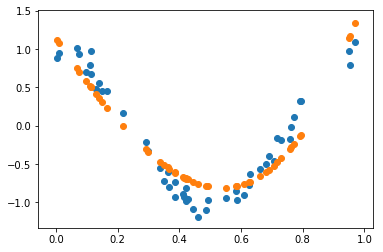

Ein:  0.05567617231836554
Eout:  0.06343416249977991
Loss function vs iterations


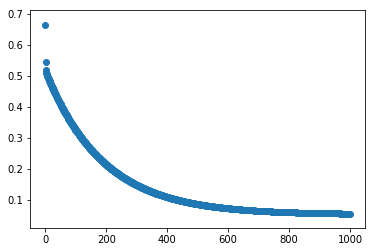

In [121]:
# Test fitData 
d, sigma, n, lambd = 3, 0.1, 50, 0
x, y = getData(n,sigma)
x2, y2 = getData(n, sigma)
Ein, Eout, lr, plot_data = fitData(x, y, d, sigma, lambd, check_grad=False)

x_poly = polynomialx(x, d)
y_pred = lr.forward(x_poly)

print("y_pred and y")
plt.scatter(x.detach().numpy(), y.detach().numpy())
#plt.scatter(x2.detach().numpy(), y2.detach().numpy())
plt.scatter(x.detach().numpy(), y_pred.detach().numpy())
plt.show()

print("Ein: ", Ein)
print("Eout: ", Eout)

xx, yy = plot_data
print("Loss function vs iterations")
plt.scatter(xx, yy)
plt.show()

### Experiments

In [124]:
def experiment(n, d, sigma, lambd, trials=20, n_test=1000):
    
    # initialize
    Ein_hist, Eout_hist = np.array([]), np.array([])
    w_hist, b_hist = np.empty([d, 0]), np.array([])

    for trail in range(trials):
        x, y = getData(n, sigma)
        Ein, Eout, lr, plot_data = fitData(x, y, d, sigma, lambd)
        Ein_hist = np.append(Ein_hist, [Ein])
        Eout_hist = np.append(Eout_hist, [Eout])

        if d != 0: w_hist = np.append(w_hist, lr.linear.weight.data.detach().numpy().reshape(-1,1), axis=1)
        b_hist = np.append(b_hist, lr.linear.bias.data.detach().numpy().reshape(-1,1))
    
    # Average
    Ein_avg = np.mean(Ein_hist)
    Eout_avg = np.mean(Eout_hist)
    if d != 0: w_avg = (1/trials)*np.sum(w_hist, axis=1).reshape(1,d)
    b_avg = np.mean(b_hist)
    
    # Create test dataset on averaged polynomials
    x_test, y_test = getData(n_test, sigma)
    
    # Create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Ebias
    if d == 0:
        w_avg = torch.from_numpy(np.zeros((1,1)))
    else:
        w_avg = torch.from_numpy(w_avg)

    b_avg = torch.Tensor([b_avg])
    lr.linear.weight.data = w_avg
    lr.linear.bias.data = b_avg
    Ebias = getMSE(lr.forward(x_test), y_test, w_avg, lambd)
    Ebias = Ebias.detach().numpy()
    Ebias = float(Ebias)
    
    return Ein_avg, Eout_avg, Ebias, w_avg

In [38]:
# Test experiment 
d, sigma, n, lambd = 2, 0.01, 5, 1
Ein_avg, Eout_avg, Ebias, w_avg = experiment(n, d, sigma, lambd)

print("Ein_avg: ", Ein_avg)
print("Eout_avg: ", Eout_avg)
print("Ebias: ", Ebias)

Ein_avg:  0.1898848881311075
Eout_avg:  1.5245190956057038
Ebias:  0.5588417700421554


### Initialize parameters for experiment
The experiment runs through combinations of different sized input, deg of features, and sigmas for f(x). A regularization rate lamba is also set. Lambda is 0 if regularization is not used.

In [125]:
bigN = [2, 5, 10, 20, 50, 100, 200]
deg = list(range(0,21))
sigmas = [0.01, 0.1, 1]
lambds = [-1e-03, 0, 1e-03]
# lambd = 5e-10
# bigN = [5, 10, 20]
# deg = [20]
# sigmas = [0.01]

numCombinations = len(bigN)*len(deg)*len(sigmas)
print(numCombinations)

441


In [ ]:
experiments = []

cntCombinations = 0
print("Number combinations: ", numCombinations)

for lambd in lambds:
    for n in bigN:
        for d in deg:
            for sigma in sigmas:
                cntCombinations+=1
                Ein_avg, Eout_avg, Ebias, w_avg = experiment(n, d, sigma, lambd, trials=20)

                print("Experiment ", cntCombinations)
                print("Inputs N, d, sigma, lambd: %s, %s, %s, %s" % (n, d, sigma, lambd))
                print("%s, %s, %s" % (Ein_avg, Eout_avg, Ebias))
                #print(w_avg)
                experiments.append([n, d, sigma, Ein_avg, Eout_avg, Ebias])

    print("done")
    #'''
    # save experiment
    with open(".\experiments\experiments_lambd_"+str(lambd), 'w', encoding="utf-8") as fout:
        pprint(experiments, fout)
    #'''